# Train language model

In [1]:
from fastai.text import *

In [2]:
path = Path('/mnt/hdd1/data/jigsaw-unintended-bias-in-toxicity-classification')
# /Documents/jigsaw-unintended-bias-in-toxicity-classification
# path = Path('/home/tony/Documents/jigsaw-unintended-bias-in-toxicity-classification')

In [9]:
train_df = pd.read_csv(path/'train.csv')

In [10]:
valid_df = pd.read_csv(path/'test.csv')

# Look at the data

In [ ]:
train_df

# Prepare language model data

## Using data bunch

In [5]:
# data_lm = TextDataBunch.from_df(path, train_df, valid_df, text_cols='comment_text')
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', text_cols='comment_text')

In [6]:
data_lm.save(path/'language_model.pkl')

# Setup model

In [5]:
bs=78

In [6]:
data_lm = load_data(path, 'language_model.pkl', bs=bs)

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn = learn.to_fp16()

In [8]:
learn = learn.load('fit')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1443899 items)
x: LMTextList
xxbos i realize that this will sound cold but i feel sorry only for the families of the deceased and for the front line first responders who have to deal with the whole mess . 
 
  i feel nothing but contempt for the people who have died from overdoses . xxmaj they chose their poison and did n't think twice about the pain they left behind .,xxbos xxmaj carney is chirping for xxmaj china while xxmaj trump is trying to make the xxup usa better . xxmaj there will be some hardship adjustments in the next few years , but 10 years from now , people will look back and say xxmaj trump was right for the xxup usa and xxmaj carney was wrong . xxmaj that 's if xxmaj mark xxmaj carney is remembered at all 10 years from now .,xxbos xxunk .,xxbos xxmaj if only things were as simple as you think they are . xxmaj while i am completely for ecumenism and the removal of the false constructs that separate us all - and , o

# Freezed train

In [7]:
learn.save('init')

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


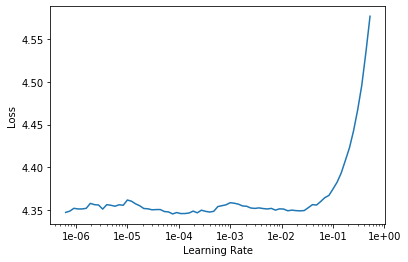

In [10]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(3, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.341383,4.226724,0.270622,1:23:02


In [ ]:
learn.save('fit')

# Unfreezed train

In [ ]:
learn.unfreeze()